# The software architecture project
## Shiraz University of Technology

In this project, we will implement a suggested architecture for clissifying big data. The used platform is Spark on Python with the aim of the standard Support Vector Liberary libSVM

## Purpose:
Check the computation time and accuracy of computation on Spark regarding the split size of bi-classed data

## Paper:
MapReduce and Spark-based architecture for bi-class classification using SVM

2018 IEEE 1st Colombian Conference on Applications in Computational Intelligence (ColCACI)

## Data:
[Covertype Data Set](https://archive.ics.uci.edu/ml/datasets/covertype)

581012 * 54 

## Steps:
1. Create a Spark context
2. Load data
3. Map each categories to binary categories
4. Create a RDD from the mapped data
5. Create the SVM model
6. Train the model
7. Make the evaluation

First we import dependencies

In [1]:
import os
import random
import numpy as np
import pandas as pd

from pyspark import SparkContext
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

from psutil import cpu_percent
from time import time

Initiallize Spark context on local

In [2]:
sc = SparkContext("local", "SVM on Spark")
sc

<SparkContext master=local appName=SVM on Spark>

Read data

In [3]:
df = pd.read_csv('./covtype.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


The size of data is:

In [4]:
df.shape

(581012, 55)

The classes we have are:

In [5]:
classes = df.iloc[:, -1].unique()
classes

array([5, 2, 1, 7, 3, 6, 4])

We generate a mapper to map original classes to binary classes randomly

In [6]:
mapper = {key:random.choice([0,1]) for key in classes}
mapper

{5: 1, 2: 1, 1: 1, 7: 1, 3: 0, 6: 0, 4: 1}

Map the original classes to the binary classes

In [7]:
mapped_categories = df.iloc[:, -1].apply(func=lambda x: mapper[x])
mapped_categories.values

array([1, 1, 1, ..., 0, 0, 0])

The number of records placed in category 1 is:

In [8]:
mapped_categories.sum()

527891

## Split data and convert to RDD for parallel training

In [19]:
training_features = df.values
training_labels = mapped_categories.values

In [22]:
labeled_points = []
for i in range(training_features.shape[0]//2):
    labeled_points.append(LabeledPoint(training_labels[i], training_features[i]))

In [29]:
results = []
for i in range(1, 6):
    parsedData = sc.parallelize(labeled_points, i)

    start_time = time()

    model = SVMWithSGD.train(parsedData, iterations=100)

    # Evaluating the model on training data
    labelsAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
    trainErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(parsedData.count())
    print("Training Error = " + str(trainErr))

    computation_time = time() - start_time
    results.append({
        'time': computation_time,
        'n_splits': parsedData.getNumPartitions(),
        'accuracy': 1-trainErr,
    })

Training Error = 0.022305984406464606
Training Error = 0.022305984406464606
Training Error = 0.022305984406464606
Training Error = 0.022305984406464606
Training Error = 0.022305984406464606


In [30]:
results

[{'time': 45.004310607910156, 'n_splits': 1, 'accuracy': 0.9776940155935354},
 {'time': 57.17976498603821, 'n_splits': 2, 'accuracy': 0.9776940155935354},
 {'time': 50.73607063293457, 'n_splits': 3, 'accuracy': 0.9776940155935354},
 {'time': 75.78839945793152, 'n_splits': 4, 'accuracy': 0.9776940155935354},
 {'time': 148.3840799331665, 'n_splits': 5, 'accuracy': 0.9776940155935354}]

In [31]:
import matplotlib
import matplotlib.pyplot as plt

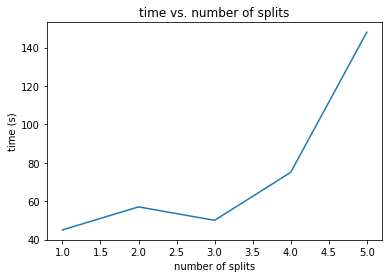

In [36]:
fig, ax = plt.subplots()
ax.plot(list(map(lambda res: int(res['n_splits']), results)), list(map(lambda res: int(res['time']), results)))
ax.set(xlabel='number of splits', ylabel='time (s)',
       title='time vs. number of splits')
plt.show()